In [1]:
import pandas as pd
import numpy as np
import sys 
import datetime
import os
import matplotlib as plt

%matplotlib inline

In [2]:
agg = {'Fare':'mean','Trip Total':'mean','Trip Miles':'sum','Trips Pooled':'sum','PRIVATE_TRIPS':'sum','SHARED_TRIPS':'sum','TRIPS':'sum'}

In [2]:
def clean_float_cols(x):
    x = x.replace(',','')
    x = float(x)
    
    return x

In [3]:
def processRawData(infile, outfile):
        """
        Reads data, cleans it, processes it, and writes it to an HDF5 file.
        
        infile  - in raw CSV format
        outfile - output file name in h5 format
        outkey = name of table in output file
        """
        
        print(datetime.datetime.now().ctime(), 'Converting raw data in file: ', infile)
        
        # set up the reader
        reader = pd.read_csv(infile,  
                         iterator = True, 
                         sep = ',', 
        parse_dates = ['Trip Start Timestamp','Trip End Timestamp'], chunksize= 25000)

        # establish the writer and clear any table with that file name
        store = pd.HDFStore(outfile)

        # iterate through chunk by chunk so we don't run out of memory
        rowsRead    = 0
        rowsWritten_weekday = 0
        rowsWritten_weekend = 0
        
        for chunk in reader:   

            rowsRead += len(chunk)
            
            #drop TNC trips that have a missing value for dropoff or pickup census tract
            #there are roughly 40 million trips with at least one end outside of Chicago
            ## These are trips outside of chicago and will be dropped for now
            ### Need to look into including them... depends on the inclusion of external trips in the chicago ABM
            chunk = chunk.dropna(subset = ['Pickup Census Tract', 'Dropoff Census Tract'])
            
            #keep only the columns of interest
            chunk = chunk[['Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds',
       'Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract',
       'Fare', 'Tip','Additional Charges', 'Trip Total', 'Shared Trip Authorized', 'Trips Pooled']]
            
            #convert columns from a string because it caused problems
            convert_cols = ['Trip Seconds','Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract','Fare', 
                            'Tip','Additional Charges', 'Trip Total', 'Trips Pooled']
        
            for column in convert_cols:
                chunk[column] = chunk[column].astype(str).apply(lambda x: x.replace(',',''))
                chunk[column] = chunk[column].astype(float)
           
            chunk['YEAR'], chunk['MONTH'], chunk['DOW'], chunk['HOUR'] = chunk['Trip Start Timestamp'].dt.year, chunk['Trip Start Timestamp'].dt.month, chunk['Trip Start Timestamp'].dt.weekday, chunk['Trip Start Timestamp'].dt.hour
            
            chunk_weekday = chunk[chunk['DOW'].isin([0,1,2,3,4])]
            chunk_weekend = chunk[chunk['DOW'].isin([5,6])]

            chunk_weekday_2 = chunk_weekday[chunk_weekday['HOUR'].isin([6])]
            chunk_weekday_3 = chunk_weekday[chunk_weekday['HOUR'].isin([7,8])]
            chunk_weekday_4 = chunk_weekday[chunk_weekday['HOUR'].isin([9])]
            chunk_weekday_5 = chunk_weekday[chunk_weekday['HOUR'].isin([10,11,12,13])]
            chunk_weekday_6 = chunk_weekday[chunk_weekday['HOUR'].isin([14,15])]
            chunk_weekday_7 = chunk_weekday[chunk_weekday['HOUR'].isin([16,17])]
            chunk_weekday_8 = chunk_weekday[chunk_weekday['HOUR'].isin([18,19])]
            chunk_weekday_1 = chunk_weekday[chunk_weekday['HOUR'].isin([20,21,22,23,24,1,2,3,4,5])]
            
            chunk_weekend_2 = chunk_weekend[chunk_weekend['HOUR'].isin([6])]
            chunk_weekend_3 = chunk_weekend[chunk_weekend['HOUR'].isin([7,8])]
            chunk_weekend_4 = chunk_weekend[chunk_weekend['HOUR'].isin([9])]
            chunk_weekend_5 = chunk_weekend[chunk_weekend['HOUR'].isin([10,11,12,13])]
            chunk_weekend_6 = chunk_weekend[chunk_weekend['HOUR'].isin([14,15])]
            chunk_weekend_7 = chunk_weekend[chunk_weekend['HOUR'].isin([16,17])]
            chunk_weekend_8 = chunk_weekend[chunk_weekend['HOUR'].isin([18,19])]
            chunk_weekend_1 = chunk_weekend[chunk_weekend['HOUR'].isin([20,21,22,23,24,1,2,3,4,5])]
            
            
            # write the data
            store.append('Weekday_1', chunk_weekday_1, data_columns = True)
            store.append('Weekday_2', chunk_weekday_2, data_columns = True)
            store.append('Weekday_3', chunk_weekday_3, data_columns = True)
            store.append('Weekday_4', chunk_weekday_4, data_columns = True)
            store.append('Weekday_5', chunk_weekday_5, data_columns = True)
            store.append('Weekday_6', chunk_weekday_6, data_columns = True)
            store.append('Weekday_7', chunk_weekday_7, data_columns = True)
            store.append('Weekday_8', chunk_weekday_8, data_columns = True)

            store.append('Weekend_1', chunk_weekend_1, data_columns = True)
            store.append('Weekend_2', chunk_weekend_2, data_columns = True)
            store.append('Weekend_3', chunk_weekend_3, data_columns = True)
            store.append('Weekend_4', chunk_weekend_4, data_columns = True)
            store.append('Weekend_5', chunk_weekend_5, data_columns = True)
            store.append('Weekend_6', chunk_weekend_6, data_columns = True)
            store.append('Weekend_7', chunk_weekend_7, data_columns = True)
            store.append('Weekend_8', chunk_weekend_8, data_columns = True)

            rowsWritten_weekday += len(chunk_weekday)
            rowsWritten_weekend += len(chunk_weekend)

            print ('Read %i rows and kept %i rows in weekday TNC table' % (rowsRead, rowsWritten_weekday))
            print ('kept ' + str(rowsWritten_weekend) + ' rows in weekend TNC table')

        store.close()
        print('Complete!!!')

In [8]:
#create the shared TNC trip h5 table
processRawData('C:/TNC Data Temp/Transportation_Network_Providers_-_Trips.csv', 'C:/TNC Data Temp/Chicago_TNC_Trips.H5')

Tue May 12 09:35:23 2020 Converting raw data in file:  C:/TNC Data Temp/Transportation_Network_Providers_-_Trips.csv


C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:157: NaturalNameWarning: object name is not a valid Python identifier: 'Trip Start Timestamp'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:157: NaturalNameWarning: object name is not a valid Python identifier: 'Trip End Timestamp'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:157: NaturalNameWarning: object name is not a valid Python identifier: 'Trip Seconds'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will st

Read 25000 rows and kept 11089 rows in weekday TNC table
kept 5625 rows in weekend TNC table
Read 50000 rows and kept 22289 rows in weekday TNC table
kept 11051 rows in weekend TNC table
Read 75000 rows and kept 33545 rows in weekday TNC table
kept 16546 rows in weekend TNC table
Read 100000 rows and kept 44718 rows in weekday TNC table
kept 22034 rows in weekend TNC table
Read 125000 rows and kept 55866 rows in weekday TNC table
kept 27533 rows in weekend TNC table
Read 150000 rows and kept 66962 rows in weekday TNC table
kept 33054 rows in weekend TNC table
Read 175000 rows and kept 78250 rows in weekday TNC table
kept 38568 rows in weekend TNC table
Read 200000 rows and kept 89476 rows in weekday TNC table
kept 44039 rows in weekend TNC table
Read 225000 rows and kept 100558 rows in weekday TNC table
kept 49695 rows in weekend TNC table
Read 250000 rows and kept 111759 rows in weekday TNC table
kept 55205 rows in weekend TNC table
Read 275000 rows and kept 122945 rows in weekday TNC

Read 2150000 rows and kept 958916 rows in weekday TNC table
kept 477482 rows in weekend TNC table
Read 2175000 rows and kept 970029 rows in weekday TNC table
kept 483094 rows in weekend TNC table
Read 2200000 rows and kept 981163 rows in weekday TNC table
kept 488570 rows in weekend TNC table
Read 2225000 rows and kept 992247 rows in weekday TNC table
kept 494230 rows in weekend TNC table
Read 2250000 rows and kept 1003508 rows in weekday TNC table
kept 499767 rows in weekend TNC table
Read 2275000 rows and kept 1014621 rows in weekday TNC table
kept 505391 rows in weekend TNC table
Read 2300000 rows and kept 1025842 rows in weekday TNC table
kept 510748 rows in weekend TNC table
Read 2325000 rows and kept 1036957 rows in weekday TNC table
kept 516219 rows in weekend TNC table
Read 2350000 rows and kept 1048148 rows in weekday TNC table
kept 521734 rows in weekend TNC table
Read 2375000 rows and kept 1059363 rows in weekday TNC table
kept 527269 rows in weekend TNC table
Read 2400000 r

Read 4225000 rows and kept 1884779 rows in weekday TNC table
kept 937757 rows in weekend TNC table
Read 4250000 rows and kept 1895967 rows in weekday TNC table
kept 943237 rows in weekend TNC table
Read 4275000 rows and kept 1907157 rows in weekday TNC table
kept 948784 rows in weekend TNC table
Read 4300000 rows and kept 1918356 rows in weekday TNC table
kept 954276 rows in weekend TNC table
Read 4325000 rows and kept 1929392 rows in weekday TNC table
kept 959853 rows in weekend TNC table
Read 4350000 rows and kept 1940471 rows in weekday TNC table
kept 965405 rows in weekend TNC table
Read 4375000 rows and kept 1951585 rows in weekday TNC table
kept 970916 rows in weekend TNC table
Read 4400000 rows and kept 1962847 rows in weekday TNC table
kept 976383 rows in weekend TNC table
Read 4425000 rows and kept 1973950 rows in weekday TNC table
kept 982050 rows in weekend TNC table
Read 4450000 rows and kept 1985127 rows in weekday TNC table
kept 987578 rows in weekend TNC table
Read 44750

Read 6300000 rows and kept 2833952 rows in weekday TNC table
kept 1389800 rows in weekend TNC table
Read 6325000 rows and kept 2845726 rows in weekday TNC table
kept 1395208 rows in weekend TNC table
Read 6350000 rows and kept 2857395 rows in weekday TNC table
kept 1400613 rows in weekend TNC table
Read 6375000 rows and kept 2869229 rows in weekday TNC table
kept 1405945 rows in weekend TNC table
Read 6400000 rows and kept 2880783 rows in weekday TNC table
kept 1411321 rows in weekend TNC table
Read 6425000 rows and kept 2892445 rows in weekday TNC table
kept 1416705 rows in weekend TNC table
Read 6450000 rows and kept 2904083 rows in weekday TNC table
kept 1422083 rows in weekend TNC table
Read 6475000 rows and kept 2915749 rows in weekday TNC table
kept 1427433 rows in weekend TNC table
Read 6500000 rows and kept 2927450 rows in weekday TNC table
kept 1432790 rows in weekend TNC table
Read 6525000 rows and kept 2939085 rows in weekday TNC table
kept 1438184 rows in weekend TNC table


Read 8350000 rows and kept 3790017 rows in weekday TNC table
kept 1831053 rows in weekend TNC table
Read 8375000 rows and kept 3801731 rows in weekday TNC table
kept 1836432 rows in weekend TNC table
Read 8400000 rows and kept 3813451 rows in weekday TNC table
kept 1841710 rows in weekend TNC table
Read 8425000 rows and kept 3825130 rows in weekday TNC table
kept 1847119 rows in weekend TNC table
Read 8450000 rows and kept 3836840 rows in weekday TNC table
kept 1852470 rows in weekend TNC table
Read 8475000 rows and kept 3848499 rows in weekday TNC table
kept 1857887 rows in weekend TNC table
Read 8500000 rows and kept 3860306 rows in weekday TNC table
kept 1863177 rows in weekend TNC table
Read 8525000 rows and kept 3872028 rows in weekday TNC table
kept 1868598 rows in weekend TNC table
Read 8550000 rows and kept 3883682 rows in weekday TNC table
kept 1873879 rows in weekend TNC table
Read 8575000 rows and kept 3895267 rows in weekday TNC table
kept 1879240 rows in weekend TNC table


Read 10400000 rows and kept 4760622 rows in weekday TNC table
kept 2305925 rows in weekend TNC table
Read 10425000 rows and kept 4772962 rows in weekday TNC table
kept 2312446 rows in weekend TNC table
Read 10450000 rows and kept 4785240 rows in weekday TNC table
kept 2318981 rows in weekend TNC table
Read 10475000 rows and kept 4797490 rows in weekday TNC table
kept 2325593 rows in weekend TNC table
Read 10500000 rows and kept 4809951 rows in weekday TNC table
kept 2332035 rows in weekend TNC table
Read 10525000 rows and kept 4822208 rows in weekday TNC table
kept 2338663 rows in weekend TNC table
Read 10550000 rows and kept 4834506 rows in weekday TNC table
kept 2345205 rows in weekend TNC table
Read 10575000 rows and kept 4846827 rows in weekday TNC table
kept 2351752 rows in weekend TNC table
Read 10600000 rows and kept 4859305 rows in weekday TNC table
kept 2358140 rows in weekend TNC table
Read 10625000 rows and kept 4871637 rows in weekday TNC table
kept 2364753 rows in weekend 

Read 12450000 rows and kept 5773625 rows in weekday TNC table
kept 2841406 rows in weekend TNC table
Read 12475000 rows and kept 5786026 rows in weekday TNC table
kept 2847929 rows in weekend TNC table
Read 12500000 rows and kept 5798334 rows in weekday TNC table
kept 2854472 rows in weekend TNC table
Read 12525000 rows and kept 5810666 rows in weekday TNC table
kept 2861021 rows in weekend TNC table
Read 12550000 rows and kept 5823016 rows in weekday TNC table
kept 2867521 rows in weekend TNC table
Read 12575000 rows and kept 5835402 rows in weekday TNC table
kept 2873995 rows in weekend TNC table
Read 12600000 rows and kept 5847765 rows in weekday TNC table
kept 2880505 rows in weekend TNC table
Read 12625000 rows and kept 5860162 rows in weekday TNC table
kept 2886922 rows in weekend TNC table
Read 12650000 rows and kept 5872339 rows in weekday TNC table
kept 2893541 rows in weekend TNC table
Read 12675000 rows and kept 5884738 rows in weekday TNC table
kept 2900038 rows in weekend 

Read 14500000 rows and kept 6787995 rows in weekday TNC table
kept 3376577 rows in weekend TNC table
Read 14525000 rows and kept 6800396 rows in weekday TNC table
kept 3383102 rows in weekend TNC table
Read 14550000 rows and kept 6812726 rows in weekday TNC table
kept 3389557 rows in weekend TNC table
Read 14575000 rows and kept 6824998 rows in weekday TNC table
kept 3396200 rows in weekend TNC table
Read 14600000 rows and kept 6837375 rows in weekday TNC table
kept 3402634 rows in weekend TNC table
Read 14625000 rows and kept 6849738 rows in weekday TNC table
kept 3409155 rows in weekend TNC table
Read 14650000 rows and kept 6862173 rows in weekday TNC table
kept 3415541 rows in weekend TNC table
Read 14675000 rows and kept 6874529 rows in weekday TNC table
kept 3422107 rows in weekend TNC table
Read 14700000 rows and kept 6887005 rows in weekday TNC table
kept 3428526 rows in weekend TNC table
Read 14725000 rows and kept 6899424 rows in weekday TNC table
kept 3435058 rows in weekend 

Read 16550000 rows and kept 7802313 rows in weekday TNC table
kept 3911853 rows in weekend TNC table
Read 16575000 rows and kept 7814601 rows in weekday TNC table
kept 3918365 rows in weekend TNC table
Read 16600000 rows and kept 7826966 rows in weekday TNC table
kept 3924786 rows in weekend TNC table
Read 16625000 rows and kept 7839364 rows in weekday TNC table
kept 3931317 rows in weekend TNC table
Read 16650000 rows and kept 7851710 rows in weekday TNC table
kept 3937926 rows in weekend TNC table
Read 16675000 rows and kept 7864104 rows in weekday TNC table
kept 3944414 rows in weekend TNC table
Read 16700000 rows and kept 7876317 rows in weekday TNC table
kept 3950918 rows in weekend TNC table
Read 16725000 rows and kept 7888618 rows in weekday TNC table
kept 3957458 rows in weekend TNC table
Read 16750000 rows and kept 7900877 rows in weekday TNC table
kept 3963988 rows in weekend TNC table
Read 16775000 rows and kept 7913240 rows in weekday TNC table
kept 3970452 rows in weekend 

Read 18600000 rows and kept 8816478 rows in weekday TNC table
kept 4446988 rows in weekend TNC table
Read 18625000 rows and kept 8828875 rows in weekday TNC table
kept 4453449 rows in weekend TNC table
Read 18650000 rows and kept 8841157 rows in weekday TNC table
kept 4459980 rows in weekend TNC table
Read 18675000 rows and kept 8853272 rows in weekday TNC table
kept 4466655 rows in weekend TNC table
Read 18700000 rows and kept 8861015 rows in weekday TNC table
kept 4470796 rows in weekend TNC table
Read 18725000 rows and kept 8861015 rows in weekday TNC table
kept 4470796 rows in weekend TNC table
Read 18750000 rows and kept 8861015 rows in weekday TNC table
kept 4470796 rows in weekend TNC table
Read 18775000 rows and kept 8861015 rows in weekday TNC table
kept 4470796 rows in weekend TNC table
Read 18800000 rows and kept 8861015 rows in weekday TNC table
kept 4470796 rows in weekend TNC table
Read 18825000 rows and kept 8861015 rows in weekday TNC table
kept 4470796 rows in weekend 

Read 20650000 rows and kept 9334399 rows in weekday TNC table
kept 4740957 rows in weekend TNC table
Read 20675000 rows and kept 9344886 rows in weekday TNC table
kept 4747003 rows in weekend TNC table
Read 20700000 rows and kept 9355612 rows in weekday TNC table
kept 4752922 rows in weekend TNC table
Read 20725000 rows and kept 9366154 rows in weekday TNC table
kept 4759039 rows in weekend TNC table
Read 20750000 rows and kept 9376635 rows in weekday TNC table
kept 4765117 rows in weekend TNC table
Read 20775000 rows and kept 9387219 rows in weekday TNC table
kept 4771129 rows in weekend TNC table
Read 20800000 rows and kept 9397720 rows in weekday TNC table
kept 4777130 rows in weekend TNC table
Read 20825000 rows and kept 9408299 rows in weekday TNC table
kept 4783210 rows in weekend TNC table
Read 20850000 rows and kept 9418796 rows in weekday TNC table
kept 4789205 rows in weekend TNC table
Read 20875000 rows and kept 9429385 rows in weekday TNC table
kept 4795188 rows in weekend 

Read 22675000 rows and kept 10265265 rows in weekday TNC table
kept 5183610 rows in weekend TNC table
Read 22700000 rows and kept 10276958 rows in weekday TNC table
kept 5189006 rows in weekend TNC table
Read 22725000 rows and kept 10288612 rows in weekday TNC table
kept 5194422 rows in weekend TNC table
Read 22750000 rows and kept 10300361 rows in weekday TNC table
kept 5199833 rows in weekend TNC table
Read 22775000 rows and kept 10312016 rows in weekday TNC table
kept 5205123 rows in weekend TNC table
Read 22800000 rows and kept 10323771 rows in weekday TNC table
kept 5210493 rows in weekend TNC table
Read 22825000 rows and kept 10335499 rows in weekday TNC table
kept 5215828 rows in weekend TNC table
Read 22850000 rows and kept 10347049 rows in weekday TNC table
kept 5221297 rows in weekend TNC table
Read 22875000 rows and kept 10358573 rows in weekday TNC table
kept 5226790 rows in weekend TNC table
Read 22900000 rows and kept 10370295 rows in weekday TNC table
kept 5232067 rows i

Read 24700000 rows and kept 11209809 rows in weekday TNC table
kept 5619500 rows in weekend TNC table
Read 24725000 rows and kept 11221388 rows in weekday TNC table
kept 5624920 rows in weekend TNC table
Read 24750000 rows and kept 11232944 rows in weekday TNC table
kept 5630405 rows in weekend TNC table
Read 24775000 rows and kept 11244631 rows in weekday TNC table
kept 5635744 rows in weekend TNC table
Read 24800000 rows and kept 11256238 rows in weekday TNC table
kept 5641117 rows in weekend TNC table
Read 24825000 rows and kept 11268006 rows in weekday TNC table
kept 5646492 rows in weekend TNC table
Read 24850000 rows and kept 11279544 rows in weekday TNC table
kept 5651943 rows in weekend TNC table
Read 24875000 rows and kept 11291145 rows in weekday TNC table
kept 5657220 rows in weekend TNC table
Read 24900000 rows and kept 11302849 rows in weekday TNC table
kept 5662544 rows in weekend TNC table
Read 24925000 rows and kept 11314482 rows in weekday TNC table
kept 5667915 rows i

Read 26725000 rows and kept 12110673 rows in weekday TNC table
kept 6050494 rows in weekend TNC table
Read 26750000 rows and kept 12122079 rows in weekday TNC table
kept 6056249 rows in weekend TNC table
Read 26775000 rows and kept 12133452 rows in weekday TNC table
kept 6061862 rows in weekend TNC table
Read 26800000 rows and kept 12144901 rows in weekday TNC table
kept 6067431 rows in weekend TNC table
Read 26825000 rows and kept 12156217 rows in weekday TNC table
kept 6073081 rows in weekend TNC table
Read 26850000 rows and kept 12167664 rows in weekday TNC table
kept 6078711 rows in weekend TNC table
Read 26875000 rows and kept 12179065 rows in weekday TNC table
kept 6084312 rows in weekend TNC table
Read 26900000 rows and kept 12190362 rows in weekday TNC table
kept 6089929 rows in weekend TNC table
Read 26925000 rows and kept 12201623 rows in weekday TNC table
kept 6095638 rows in weekend TNC table
Read 26950000 rows and kept 12212929 rows in weekday TNC table
kept 6101264 rows i

Read 28750000 rows and kept 13028827 rows in weekday TNC table
kept 6507034 rows in weekend TNC table
Read 28775000 rows and kept 13039986 rows in weekday TNC table
kept 6512804 rows in weekend TNC table
Read 28800000 rows and kept 13051396 rows in weekday TNC table
kept 6518341 rows in weekend TNC table
Read 28825000 rows and kept 13062841 rows in weekday TNC table
kept 6523884 rows in weekend TNC table
Read 28850000 rows and kept 13074000 rows in weekday TNC table
kept 6529568 rows in weekend TNC table
Read 28875000 rows and kept 13085447 rows in weekday TNC table
kept 6535154 rows in weekend TNC table
Read 28900000 rows and kept 13096705 rows in weekday TNC table
kept 6540800 rows in weekend TNC table
Read 28925000 rows and kept 13108057 rows in weekday TNC table
kept 6546461 rows in weekend TNC table
Read 28950000 rows and kept 13119422 rows in weekday TNC table
kept 6552097 rows in weekend TNC table
Read 28975000 rows and kept 13130814 rows in weekday TNC table
kept 6557864 rows i

Read 30775000 rows and kept 13947546 rows in weekday TNC table
kept 6963499 rows in weekend TNC table
Read 30800000 rows and kept 13958874 rows in weekday TNC table
kept 6969239 rows in weekend TNC table
Read 30825000 rows and kept 13970278 rows in weekday TNC table
kept 6974809 rows in weekend TNC table
Read 30850000 rows and kept 13981676 rows in weekday TNC table
kept 6980426 rows in weekend TNC table
Read 30875000 rows and kept 13993026 rows in weekday TNC table
kept 6986046 rows in weekend TNC table
Read 30900000 rows and kept 14004303 rows in weekday TNC table
kept 6991653 rows in weekend TNC table
Read 30925000 rows and kept 14015549 rows in weekday TNC table
kept 6997280 rows in weekend TNC table
Read 30950000 rows and kept 14027024 rows in weekday TNC table
kept 7002742 rows in weekend TNC table
Read 30975000 rows and kept 14038268 rows in weekday TNC table
kept 7008464 rows in weekend TNC table
Read 31000000 rows and kept 14049683 rows in weekday TNC table
kept 7014027 rows i

Read 32800000 rows and kept 14865293 rows in weekday TNC table
kept 7419507 rows in weekend TNC table
Read 32825000 rows and kept 14876594 rows in weekday TNC table
kept 7425131 rows in weekend TNC table
Read 32850000 rows and kept 14887965 rows in weekday TNC table
kept 7430710 rows in weekend TNC table
Read 32875000 rows and kept 14899449 rows in weekday TNC table
kept 7436211 rows in weekend TNC table
Read 32900000 rows and kept 14910805 rows in weekday TNC table
kept 7441799 rows in weekend TNC table
Read 32925000 rows and kept 14922047 rows in weekday TNC table
kept 7447530 rows in weekend TNC table
Read 32950000 rows and kept 14933286 rows in weekday TNC table
kept 7453119 rows in weekend TNC table
Read 32975000 rows and kept 14944600 rows in weekday TNC table
kept 7458677 rows in weekend TNC table
Read 33000000 rows and kept 14955932 rows in weekday TNC table
kept 7464239 rows in weekend TNC table
Read 33025000 rows and kept 14967285 rows in weekday TNC table
kept 7469859 rows i

Read 34825000 rows and kept 15783304 rows in weekday TNC table
kept 7875646 rows in weekend TNC table
Read 34850000 rows and kept 15794490 rows in weekday TNC table
kept 7881425 rows in weekend TNC table
Read 34875000 rows and kept 15805794 rows in weekday TNC table
kept 7887075 rows in weekend TNC table
Read 34900000 rows and kept 15817047 rows in weekday TNC table
kept 7892784 rows in weekend TNC table
Read 34925000 rows and kept 15828427 rows in weekday TNC table
kept 7898398 rows in weekend TNC table
Read 34950000 rows and kept 15839747 rows in weekday TNC table
kept 7904088 rows in weekend TNC table
Read 34975000 rows and kept 15851090 rows in weekday TNC table
kept 7909728 rows in weekend TNC table
Read 35000000 rows and kept 15862460 rows in weekday TNC table
kept 7915409 rows in weekend TNC table
Read 35025000 rows and kept 15873858 rows in weekday TNC table
kept 7921023 rows in weekend TNC table
Read 35050000 rows and kept 15885149 rows in weekday TNC table
kept 7926749 rows i

Read 36850000 rows and kept 16702128 rows in weekday TNC table
kept 8331723 rows in weekend TNC table
Read 36875000 rows and kept 16713586 rows in weekday TNC table
kept 8337323 rows in weekend TNC table
Read 36900000 rows and kept 16724969 rows in weekday TNC table
kept 8342872 rows in weekend TNC table
Read 36925000 rows and kept 16736056 rows in weekday TNC table
kept 8348571 rows in weekend TNC table
Read 36950000 rows and kept 16747346 rows in weekday TNC table
kept 8354274 rows in weekend TNC table
Read 36975000 rows and kept 16758628 rows in weekday TNC table
kept 8359949 rows in weekend TNC table
Read 37000000 rows and kept 16769812 rows in weekday TNC table
kept 8365592 rows in weekend TNC table
Read 37025000 rows and kept 16781229 rows in weekday TNC table
kept 8371182 rows in weekend TNC table
Read 37050000 rows and kept 16792629 rows in weekday TNC table
kept 8376774 rows in weekend TNC table
Read 37075000 rows and kept 16804016 rows in weekday TNC table
kept 8382347 rows i

Read 38875000 rows and kept 17620837 rows in weekday TNC table
kept 8787322 rows in weekend TNC table
Read 38900000 rows and kept 17632212 rows in weekday TNC table
kept 8792899 rows in weekend TNC table
Read 38925000 rows and kept 17643599 rows in weekday TNC table
kept 8798581 rows in weekend TNC table
Read 38950000 rows and kept 17654991 rows in weekday TNC table
kept 8804194 rows in weekend TNC table
Read 38975000 rows and kept 17666306 rows in weekday TNC table
kept 8809832 rows in weekend TNC table
Read 39000000 rows and kept 17677596 rows in weekday TNC table
kept 8815433 rows in weekend TNC table
Read 39025000 rows and kept 17688810 rows in weekday TNC table
kept 8821163 rows in weekend TNC table
Read 39050000 rows and kept 17700171 rows in weekday TNC table
kept 8826807 rows in weekend TNC table
Read 39075000 rows and kept 17711433 rows in weekday TNC table
kept 8832389 rows in weekend TNC table
Read 39100000 rows and kept 17722853 rows in weekday TNC table
kept 8837949 rows i

Read 40900000 rows and kept 18537843 rows in weekday TNC table
kept 9243238 rows in weekend TNC table
Read 40925000 rows and kept 18549158 rows in weekday TNC table
kept 9248888 rows in weekend TNC table
Read 40950000 rows and kept 18560314 rows in weekday TNC table
kept 9254563 rows in weekend TNC table
Read 40975000 rows and kept 18571617 rows in weekday TNC table
kept 9260165 rows in weekend TNC table
Read 41000000 rows and kept 18582959 rows in weekday TNC table
kept 9265890 rows in weekend TNC table
Read 41025000 rows and kept 18594264 rows in weekday TNC table
kept 9271513 rows in weekend TNC table
Read 41050000 rows and kept 18605621 rows in weekday TNC table
kept 9277125 rows in weekend TNC table
Read 41075000 rows and kept 18616967 rows in weekday TNC table
kept 9282782 rows in weekend TNC table
Read 41100000 rows and kept 18628122 rows in weekday TNC table
kept 9288480 rows in weekend TNC table
Read 41125000 rows and kept 18639598 rows in weekday TNC table
kept 9294065 rows i

Read 42925000 rows and kept 19456171 rows in weekday TNC table
kept 9699198 rows in weekend TNC table
Read 42950000 rows and kept 19467545 rows in weekday TNC table
kept 9704893 rows in weekend TNC table
Read 42975000 rows and kept 19478918 rows in weekday TNC table
kept 9710580 rows in weekend TNC table
Read 43000000 rows and kept 19490265 rows in weekday TNC table
kept 9716194 rows in weekend TNC table
Read 43025000 rows and kept 19501597 rows in weekday TNC table
kept 9721810 rows in weekend TNC table
Read 43050000 rows and kept 19513011 rows in weekday TNC table
kept 9727385 rows in weekend TNC table
Read 43075000 rows and kept 19524300 rows in weekday TNC table
kept 9732973 rows in weekend TNC table
Read 43100000 rows and kept 19535702 rows in weekday TNC table
kept 9738552 rows in weekend TNC table
Read 43125000 rows and kept 19547126 rows in weekday TNC table
kept 9744073 rows in weekend TNC table
Read 43150000 rows and kept 19558470 rows in weekday TNC table
kept 9749793 rows i

Read 44950000 rows and kept 20376209 rows in weekday TNC table
kept 10155238 rows in weekend TNC table
Read 44975000 rows and kept 20387639 rows in weekday TNC table
kept 10160856 rows in weekend TNC table
Read 45000000 rows and kept 20398968 rows in weekday TNC table
kept 10166521 rows in weekend TNC table
Read 45025000 rows and kept 20410346 rows in weekday TNC table
kept 10172127 rows in weekend TNC table
Read 45050000 rows and kept 20421604 rows in weekday TNC table
kept 10177716 rows in weekend TNC table
Read 45075000 rows and kept 20432938 rows in weekday TNC table
kept 10183313 rows in weekend TNC table
Read 45100000 rows and kept 20444207 rows in weekday TNC table
kept 10188941 rows in weekend TNC table
Read 45125000 rows and kept 20455472 rows in weekday TNC table
kept 10194567 rows in weekend TNC table
Read 45150000 rows and kept 20466876 rows in weekday TNC table
kept 10200262 rows in weekend TNC table
Read 45175000 rows and kept 20478194 rows in weekday TNC table
kept 10205

Read 46950000 rows and kept 21283970 rows in weekday TNC table
kept 10605642 rows in weekend TNC table
Read 46975000 rows and kept 21295331 rows in weekday TNC table
kept 10611310 rows in weekend TNC table
Read 47000000 rows and kept 21306607 rows in weekday TNC table
kept 10616933 rows in weekend TNC table
Read 47025000 rows and kept 21317942 rows in weekday TNC table
kept 10622523 rows in weekend TNC table
Read 47050000 rows and kept 21329360 rows in weekday TNC table
kept 10628011 rows in weekend TNC table
Read 47075000 rows and kept 21340656 rows in weekday TNC table
kept 10633699 rows in weekend TNC table
Read 47100000 rows and kept 21351924 rows in weekday TNC table
kept 10639391 rows in weekend TNC table
Read 47125000 rows and kept 21363354 rows in weekday TNC table
kept 10645007 rows in weekend TNC table
Read 47150000 rows and kept 21374568 rows in weekday TNC table
kept 10650682 rows in weekend TNC table
Read 47175000 rows and kept 21385880 rows in weekday TNC table
kept 10656

Read 48950000 rows and kept 22191443 rows in weekday TNC table
kept 11055337 rows in weekend TNC table
Read 48975000 rows and kept 22202702 rows in weekday TNC table
kept 11060998 rows in weekend TNC table
Read 49000000 rows and kept 22214101 rows in weekday TNC table
kept 11066561 rows in weekend TNC table
Read 49025000 rows and kept 22225465 rows in weekday TNC table
kept 11072203 rows in weekend TNC table
Read 49050000 rows and kept 22236767 rows in weekday TNC table
kept 11077871 rows in weekend TNC table
Read 49075000 rows and kept 22248090 rows in weekday TNC table
kept 11083489 rows in weekend TNC table
Read 49100000 rows and kept 22259435 rows in weekday TNC table
kept 11089252 rows in weekend TNC table
Read 49125000 rows and kept 22270740 rows in weekday TNC table
kept 11094970 rows in weekend TNC table
Read 49150000 rows and kept 22282076 rows in weekday TNC table
kept 11100643 rows in weekend TNC table
Read 49175000 rows and kept 22293348 rows in weekday TNC table
kept 11106

Read 50950000 rows and kept 23097013 rows in weekday TNC table
kept 11506184 rows in weekend TNC table
Read 50975000 rows and kept 23108287 rows in weekday TNC table
kept 11511953 rows in weekend TNC table
Read 51000000 rows and kept 23119644 rows in weekday TNC table
kept 11517588 rows in weekend TNC table
Read 51025000 rows and kept 23130869 rows in weekday TNC table
kept 11523248 rows in weekend TNC table
Read 51050000 rows and kept 23142330 rows in weekday TNC table
kept 11528799 rows in weekend TNC table
Read 51075000 rows and kept 23153566 rows in weekday TNC table
kept 11534512 rows in weekend TNC table
Read 51100000 rows and kept 23164836 rows in weekday TNC table
kept 11540186 rows in weekend TNC table
Read 51125000 rows and kept 23176137 rows in weekday TNC table
kept 11545803 rows in weekend TNC table
Read 51150000 rows and kept 23187516 rows in weekday TNC table
kept 11551457 rows in weekend TNC table
Read 51175000 rows and kept 23199016 rows in weekday TNC table
kept 11556

Read 52950000 rows and kept 24004935 rows in weekday TNC table
kept 11957530 rows in weekend TNC table
Read 52975000 rows and kept 24016291 rows in weekday TNC table
kept 11963108 rows in weekend TNC table
Read 53000000 rows and kept 24027582 rows in weekday TNC table
kept 11968746 rows in weekend TNC table
Read 53025000 rows and kept 24038925 rows in weekday TNC table
kept 11974375 rows in weekend TNC table
Read 53050000 rows and kept 24050290 rows in weekday TNC table
kept 11979963 rows in weekend TNC table
Read 53075000 rows and kept 24061748 rows in weekday TNC table
kept 11985569 rows in weekend TNC table
Read 53100000 rows and kept 24073228 rows in weekday TNC table
kept 11991160 rows in weekend TNC table
Read 53125000 rows and kept 24084667 rows in weekday TNC table
kept 11996760 rows in weekend TNC table
Read 53150000 rows and kept 24096110 rows in weekday TNC table
kept 12002386 rows in weekend TNC table
Read 53175000 rows and kept 24107255 rows in weekday TNC table
kept 12008

Read 54950000 rows and kept 24923904 rows in weekday TNC table
kept 12398465 rows in weekend TNC table
Read 54975000 rows and kept 24935637 rows in weekday TNC table
kept 12403776 rows in weekend TNC table
Read 55000000 rows and kept 24947260 rows in weekday TNC table
kept 12409201 rows in weekend TNC table
Read 55025000 rows and kept 24959041 rows in weekday TNC table
kept 12414572 rows in weekend TNC table
Read 55050000 rows and kept 24970621 rows in weekday TNC table
kept 12419904 rows in weekend TNC table
Read 55075000 rows and kept 24982196 rows in weekday TNC table
kept 12425270 rows in weekend TNC table
Read 55100000 rows and kept 24993935 rows in weekday TNC table
kept 12430586 rows in weekend TNC table
Read 55125000 rows and kept 25005766 rows in weekday TNC table
kept 12435926 rows in weekend TNC table
Read 55150000 rows and kept 25017296 rows in weekday TNC table
kept 12441323 rows in weekend TNC table
Read 55175000 rows and kept 25028910 rows in weekday TNC table
kept 12446

Read 56950000 rows and kept 25856428 rows in weekday TNC table
kept 12829116 rows in weekend TNC table
Read 56975000 rows and kept 25868047 rows in weekday TNC table
kept 12834468 rows in weekend TNC table
Read 57000000 rows and kept 25879717 rows in weekday TNC table
kept 12839887 rows in weekend TNC table
Read 57025000 rows and kept 25891306 rows in weekday TNC table
kept 12845315 rows in weekend TNC table
Read 57050000 rows and kept 25903133 rows in weekday TNC table
kept 12850659 rows in weekend TNC table
Read 57075000 rows and kept 25914713 rows in weekday TNC table
kept 12856124 rows in weekend TNC table
Read 57100000 rows and kept 25926329 rows in weekday TNC table
kept 12861471 rows in weekend TNC table
Read 57125000 rows and kept 25938085 rows in weekday TNC table
kept 12866812 rows in weekend TNC table
Read 57150000 rows and kept 25949804 rows in weekday TNC table
kept 12872177 rows in weekend TNC table
Read 57175000 rows and kept 25961306 rows in weekday TNC table
kept 12877

Read 58950000 rows and kept 26787411 rows in weekday TNC table
kept 13260254 rows in weekend TNC table
Read 58975000 rows and kept 26799110 rows in weekday TNC table
kept 13265566 rows in weekend TNC table
Read 59000000 rows and kept 26810657 rows in weekday TNC table
kept 13270854 rows in weekend TNC table
Read 59025000 rows and kept 26822331 rows in weekday TNC table
kept 13276271 rows in weekend TNC table
Read 59050000 rows and kept 26833823 rows in weekday TNC table
kept 13281707 rows in weekend TNC table
Read 59075000 rows and kept 26845376 rows in weekday TNC table
kept 13287289 rows in weekend TNC table
Read 59100000 rows and kept 26857042 rows in weekday TNC table
kept 13292677 rows in weekend TNC table
Read 59125000 rows and kept 26868502 rows in weekday TNC table
kept 13298166 rows in weekend TNC table
Read 59150000 rows and kept 26880208 rows in weekday TNC table
kept 13303544 rows in weekend TNC table
Read 59175000 rows and kept 26891770 rows in weekday TNC table
kept 13308

Read 60950000 rows and kept 27719206 rows in weekday TNC table
kept 13689720 rows in weekend TNC table
Read 60975000 rows and kept 27730793 rows in weekday TNC table
kept 13695178 rows in weekend TNC table
Read 61000000 rows and kept 27742474 rows in weekday TNC table
kept 13700545 rows in weekend TNC table
Read 61025000 rows and kept 27754036 rows in weekday TNC table
kept 13705935 rows in weekend TNC table
Read 61050000 rows and kept 27765667 rows in weekday TNC table
kept 13711356 rows in weekend TNC table
Read 61075000 rows and kept 27777350 rows in weekday TNC table
kept 13716816 rows in weekend TNC table
Read 61100000 rows and kept 27789000 rows in weekday TNC table
kept 13722191 rows in weekend TNC table
Read 61125000 rows and kept 27800728 rows in weekday TNC table
kept 13727549 rows in weekend TNC table
Read 61150000 rows and kept 27812442 rows in weekday TNC table
kept 13732862 rows in weekend TNC table
Read 61175000 rows and kept 27824047 rows in weekday TNC table
kept 13738

Read 62950000 rows and kept 28650518 rows in weekday TNC table
kept 14120581 rows in weekend TNC table
Read 62975000 rows and kept 28662311 rows in weekday TNC table
kept 14125893 rows in weekend TNC table
Read 63000000 rows and kept 28673987 rows in weekday TNC table
kept 14131295 rows in weekend TNC table
Read 63025000 rows and kept 28685707 rows in weekday TNC table
kept 14136646 rows in weekend TNC table
Read 63050000 rows and kept 28697337 rows in weekday TNC table
kept 14142006 rows in weekend TNC table
Read 63075000 rows and kept 28708935 rows in weekday TNC table
kept 14147435 rows in weekend TNC table
Read 63100000 rows and kept 28720548 rows in weekday TNC table
kept 14152822 rows in weekend TNC table
Read 63125000 rows and kept 28732304 rows in weekday TNC table
kept 14158269 rows in weekend TNC table
Read 63150000 rows and kept 28743987 rows in weekday TNC table
kept 14163640 rows in weekend TNC table
Read 63175000 rows and kept 28755593 rows in weekday TNC table
kept 14169

Read 64950000 rows and kept 29582367 rows in weekday TNC table
kept 14551449 rows in weekend TNC table
Read 64975000 rows and kept 29594000 rows in weekday TNC table
kept 14556884 rows in weekend TNC table
Read 65000000 rows and kept 29605618 rows in weekday TNC table
kept 14562351 rows in weekend TNC table
Read 65025000 rows and kept 29617356 rows in weekday TNC table
kept 14567721 rows in weekend TNC table
Read 65050000 rows and kept 29629182 rows in weekday TNC table
kept 14572974 rows in weekend TNC table
Read 65075000 rows and kept 29640869 rows in weekday TNC table
kept 14578225 rows in weekend TNC table
Read 65100000 rows and kept 29652725 rows in weekday TNC table
kept 14583485 rows in weekend TNC table
Read 65125000 rows and kept 29664491 rows in weekday TNC table
kept 14588747 rows in weekend TNC table
Read 65150000 rows and kept 29675997 rows in weekday TNC table
kept 14594212 rows in weekend TNC table
Read 65175000 rows and kept 29687727 rows in weekday TNC table
kept 14599

Read 66950000 rows and kept 30515446 rows in weekday TNC table
kept 14981359 rows in weekend TNC table
Read 66975000 rows and kept 30527142 rows in weekday TNC table
kept 14986663 rows in weekend TNC table
Read 67000000 rows and kept 30538742 rows in weekday TNC table
kept 14992129 rows in weekend TNC table
Read 67025000 rows and kept 30550355 rows in weekday TNC table
kept 14997555 rows in weekend TNC table
Read 67050000 rows and kept 30562021 rows in weekday TNC table
kept 15002978 rows in weekend TNC table
Read 67075000 rows and kept 30573685 rows in weekday TNC table
kept 15008416 rows in weekend TNC table
Read 67100000 rows and kept 30585390 rows in weekday TNC table
kept 15013797 rows in weekend TNC table
Read 67125000 rows and kept 30597080 rows in weekday TNC table
kept 15019109 rows in weekend TNC table
Read 67150000 rows and kept 30608699 rows in weekday TNC table
kept 15024584 rows in weekend TNC table
Read 67175000 rows and kept 30620182 rows in weekday TNC table
kept 15029

Read 68950000 rows and kept 31447759 rows in weekday TNC table
kept 15411977 rows in weekend TNC table
Read 68975000 rows and kept 31459504 rows in weekday TNC table
kept 15417356 rows in weekend TNC table
Read 69000000 rows and kept 31471128 rows in weekday TNC table
kept 15422775 rows in weekend TNC table
Read 69025000 rows and kept 31482922 rows in weekday TNC table
kept 15428137 rows in weekend TNC table
Read 69050000 rows and kept 31494460 rows in weekday TNC table
kept 15433464 rows in weekend TNC table
Read 69075000 rows and kept 31506049 rows in weekday TNC table
kept 15438864 rows in weekend TNC table
Read 69100000 rows and kept 31517637 rows in weekday TNC table
kept 15444297 rows in weekend TNC table
Read 69125000 rows and kept 31529267 rows in weekday TNC table
kept 15449747 rows in weekend TNC table
Read 69150000 rows and kept 31540923 rows in weekday TNC table
kept 15455176 rows in weekend TNC table
Read 69175000 rows and kept 31552556 rows in weekday TNC table
kept 15460

Read 70950000 rows and kept 32380654 rows in weekday TNC table
kept 15842570 rows in weekend TNC table
Read 70975000 rows and kept 32392272 rows in weekday TNC table
kept 15847930 rows in weekend TNC table
Read 71000000 rows and kept 32403878 rows in weekday TNC table
kept 15853303 rows in weekend TNC table
Read 71025000 rows and kept 32415535 rows in weekday TNC table
kept 15858675 rows in weekend TNC table
Read 71050000 rows and kept 32427197 rows in weekday TNC table
kept 15863993 rows in weekend TNC table
Read 71075000 rows and kept 32438792 rows in weekday TNC table
kept 15869359 rows in weekend TNC table
Read 71100000 rows and kept 32450358 rows in weekday TNC table
kept 15874723 rows in weekend TNC table
Read 71125000 rows and kept 32462073 rows in weekday TNC table
kept 15880049 rows in weekend TNC table
Read 71150000 rows and kept 32473811 rows in weekday TNC table
kept 15885395 rows in weekend TNC table
Read 71175000 rows and kept 32485491 rows in weekday TNC table
kept 15890

Read 72950000 rows and kept 33312212 rows in weekday TNC table
kept 16273004 rows in weekend TNC table
Read 72975000 rows and kept 33323665 rows in weekday TNC table
kept 16278407 rows in weekend TNC table
Read 73000000 rows and kept 33335259 rows in weekday TNC table
kept 16283735 rows in weekend TNC table
Read 73025000 rows and kept 33346786 rows in weekday TNC table
kept 16289144 rows in weekend TNC table
Read 73050000 rows and kept 33358303 rows in weekday TNC table
kept 16294565 rows in weekend TNC table
Read 73075000 rows and kept 33369784 rows in weekday TNC table
kept 16300002 rows in weekend TNC table
Read 73100000 rows and kept 33381463 rows in weekday TNC table
kept 16305326 rows in weekend TNC table
Read 73125000 rows and kept 33393183 rows in weekday TNC table
kept 16310701 rows in weekend TNC table
Read 73150000 rows and kept 33404836 rows in weekday TNC table
kept 16316188 rows in weekend TNC table
Read 73175000 rows and kept 33416628 rows in weekday TNC table
kept 16321

Read 74950000 rows and kept 34244008 rows in weekday TNC table
kept 16703144 rows in weekend TNC table
Read 74975000 rows and kept 34255847 rows in weekday TNC table
kept 16708514 rows in weekend TNC table
Read 75000000 rows and kept 34267581 rows in weekday TNC table
kept 16713967 rows in weekend TNC table
Read 75025000 rows and kept 34279141 rows in weekday TNC table
kept 16719316 rows in weekend TNC table
Read 75050000 rows and kept 34290844 rows in weekday TNC table
kept 16724671 rows in weekend TNC table
Read 75075000 rows and kept 34302527 rows in weekday TNC table
kept 16729984 rows in weekend TNC table
Read 75100000 rows and kept 34314331 rows in weekday TNC table
kept 16735327 rows in weekend TNC table
Read 75125000 rows and kept 34326059 rows in weekday TNC table
kept 16740593 rows in weekend TNC table
Read 75150000 rows and kept 34337693 rows in weekday TNC table
kept 16746123 rows in weekend TNC table
Read 75175000 rows and kept 34349384 rows in weekday TNC table
kept 16751

Read 76950000 rows and kept 35176964 rows in weekday TNC table
kept 17133072 rows in weekend TNC table
Read 76975000 rows and kept 35188597 rows in weekday TNC table
kept 17138506 rows in weekend TNC table
Read 77000000 rows and kept 35200342 rows in weekday TNC table
kept 17143892 rows in weekend TNC table
Read 77025000 rows and kept 35211845 rows in weekday TNC table
kept 17149357 rows in weekend TNC table
Read 77050000 rows and kept 35223342 rows in weekday TNC table
kept 17154785 rows in weekend TNC table
Read 77075000 rows and kept 35235074 rows in weekday TNC table
kept 17160092 rows in weekend TNC table
Read 77100000 rows and kept 35246860 rows in weekday TNC table
kept 17165345 rows in weekend TNC table
Read 77125000 rows and kept 35258766 rows in weekday TNC table
kept 17170598 rows in weekend TNC table
Read 77150000 rows and kept 35270411 rows in weekday TNC table
kept 17175993 rows in weekend TNC table
Read 77175000 rows and kept 35282001 rows in weekday TNC table
kept 17181

Read 78950000 rows and kept 36087588 rows in weekday TNC table
kept 17573074 rows in weekend TNC table
Read 78975000 rows and kept 36098548 rows in weekday TNC table
kept 17578709 rows in weekend TNC table
Read 79000000 rows and kept 36109593 rows in weekday TNC table
kept 17584374 rows in weekend TNC table
Read 79025000 rows and kept 36120657 rows in weekday TNC table
kept 17590097 rows in weekend TNC table
Read 79050000 rows and kept 36131642 rows in weekday TNC table
kept 17595775 rows in weekend TNC table
Read 79075000 rows and kept 36142820 rows in weekday TNC table
kept 17601498 rows in weekend TNC table
Read 79100000 rows and kept 36153903 rows in weekday TNC table
kept 17607221 rows in weekend TNC table
Read 79125000 rows and kept 36164880 rows in weekday TNC table
kept 17612915 rows in weekend TNC table
Read 79150000 rows and kept 36175830 rows in weekday TNC table
kept 17618572 rows in weekend TNC table
Read 79175000 rows and kept 36186749 rows in weekday TNC table
kept 17624

Read 80950000 rows and kept 36969812 rows in weekday TNC table
kept 18025692 rows in weekend TNC table
Read 80975000 rows and kept 36980722 rows in weekday TNC table
kept 18031305 rows in weekend TNC table
Read 81000000 rows and kept 36991681 rows in weekday TNC table
kept 18036993 rows in weekend TNC table
Read 81025000 rows and kept 37002789 rows in weekday TNC table
kept 18042591 rows in weekend TNC table
Read 81050000 rows and kept 37013781 rows in weekday TNC table
kept 18048228 rows in weekend TNC table
Read 81075000 rows and kept 37024899 rows in weekday TNC table
kept 18053861 rows in weekend TNC table
Read 81100000 rows and kept 37036018 rows in weekday TNC table
kept 18059498 rows in weekend TNC table
Read 81125000 rows and kept 37047163 rows in weekday TNC table
kept 18065277 rows in weekend TNC table
Read 81150000 rows and kept 37058138 rows in weekday TNC table
kept 18071008 rows in weekend TNC table
Read 81175000 rows and kept 37069186 rows in weekday TNC table
kept 18076

Read 82950000 rows and kept 37850559 rows in weekday TNC table
kept 18479045 rows in weekend TNC table
Read 82975000 rows and kept 37861619 rows in weekday TNC table
kept 18484603 rows in weekend TNC table
Read 83000000 rows and kept 37872594 rows in weekday TNC table
kept 18490319 rows in weekend TNC table
Read 83025000 rows and kept 37883572 rows in weekday TNC table
kept 18496010 rows in weekend TNC table
Read 83050000 rows and kept 37894608 rows in weekday TNC table
kept 18501768 rows in weekend TNC table
Read 83075000 rows and kept 37905628 rows in weekday TNC table
kept 18507463 rows in weekend TNC table
Read 83100000 rows and kept 37916691 rows in weekday TNC table
kept 18512995 rows in weekend TNC table
Read 83125000 rows and kept 37927611 rows in weekday TNC table
kept 18518796 rows in weekend TNC table
Read 83150000 rows and kept 37938667 rows in weekday TNC table
kept 18524416 rows in weekend TNC table
Read 83175000 rows and kept 37949659 rows in weekday TNC table
kept 18530

Read 84950000 rows and kept 38731134 rows in weekday TNC table
kept 18932034 rows in weekend TNC table
Read 84975000 rows and kept 38742235 rows in weekday TNC table
kept 18937741 rows in weekend TNC table
Read 85000000 rows and kept 38753296 rows in weekday TNC table
kept 18943393 rows in weekend TNC table
Read 85025000 rows and kept 38764340 rows in weekday TNC table
kept 18948939 rows in weekend TNC table
Read 85050000 rows and kept 38775404 rows in weekday TNC table
kept 18954569 rows in weekend TNC table
Read 85075000 rows and kept 38786434 rows in weekday TNC table
kept 18960208 rows in weekend TNC table
Read 85100000 rows and kept 38797450 rows in weekday TNC table
kept 18965939 rows in weekend TNC table
Read 85125000 rows and kept 38808379 rows in weekday TNC table
kept 18971595 rows in weekend TNC table
Read 85150000 rows and kept 38819309 rows in weekday TNC table
kept 18977345 rows in weekend TNC table
Read 85175000 rows and kept 38830439 rows in weekday TNC table
kept 18982

Read 86950000 rows and kept 39612567 rows in weekday TNC table
kept 19385578 rows in weekend TNC table
Read 86975000 rows and kept 39623559 rows in weekday TNC table
kept 19391260 rows in weekend TNC table
Read 87000000 rows and kept 39634593 rows in weekday TNC table
kept 19396907 rows in weekend TNC table
Read 87025000 rows and kept 39645568 rows in weekday TNC table
kept 19402581 rows in weekend TNC table
Read 87050000 rows and kept 39656562 rows in weekday TNC table
kept 19408234 rows in weekend TNC table
Read 87075000 rows and kept 39667542 rows in weekday TNC table
kept 19413877 rows in weekend TNC table
Read 87100000 rows and kept 39678528 rows in weekday TNC table
kept 19419568 rows in weekend TNC table
Read 87125000 rows and kept 39689445 rows in weekday TNC table
kept 19425244 rows in weekend TNC table
Read 87150000 rows and kept 39700439 rows in weekday TNC table
kept 19430923 rows in weekend TNC table
Read 87175000 rows and kept 39711476 rows in weekday TNC table
kept 19436

Read 88950000 rows and kept 40492946 rows in weekday TNC table
kept 19838504 rows in weekend TNC table
Read 88975000 rows and kept 40504038 rows in weekday TNC table
kept 19844037 rows in weekend TNC table
Read 89000000 rows and kept 40514986 rows in weekday TNC table
kept 19849665 rows in weekend TNC table
Read 89025000 rows and kept 40526096 rows in weekday TNC table
kept 19855283 rows in weekend TNC table
Read 89050000 rows and kept 40537110 rows in weekday TNC table
kept 19860974 rows in weekend TNC table
Read 89075000 rows and kept 40548048 rows in weekday TNC table
kept 19866666 rows in weekend TNC table
Read 89100000 rows and kept 40559015 rows in weekday TNC table
kept 19872506 rows in weekend TNC table
Read 89125000 rows and kept 40569995 rows in weekday TNC table
kept 19878210 rows in weekend TNC table
Read 89150000 rows and kept 40581114 rows in weekday TNC table
kept 19883874 rows in weekend TNC table
Read 89175000 rows and kept 40592224 rows in weekday TNC table
kept 19889

Read 90950000 rows and kept 41374200 rows in weekday TNC table
kept 20290985 rows in weekend TNC table
Read 90975000 rows and kept 41385189 rows in weekday TNC table
kept 20296643 rows in weekend TNC table
Read 91000000 rows and kept 41396190 rows in weekday TNC table
kept 20302376 rows in weekend TNC table
Read 91025000 rows and kept 41407093 rows in weekday TNC table
kept 20308041 rows in weekend TNC table
Read 91050000 rows and kept 41418031 rows in weekday TNC table
kept 20313753 rows in weekend TNC table
Read 91075000 rows and kept 41429115 rows in weekday TNC table
kept 20319305 rows in weekend TNC table
Read 91100000 rows and kept 41440236 rows in weekday TNC table
kept 20324948 rows in weekend TNC table
Read 91125000 rows and kept 41451197 rows in weekday TNC table
kept 20330662 rows in weekend TNC table
Read 91150000 rows and kept 41462233 rows in weekday TNC table
kept 20336291 rows in weekend TNC table
Read 91175000 rows and kept 41473259 rows in weekday TNC table
kept 20341

Read 92950000 rows and kept 42255802 rows in weekday TNC table
kept 20744235 rows in weekend TNC table
Read 92975000 rows and kept 42266837 rows in weekday TNC table
kept 20749904 rows in weekend TNC table
Read 93000000 rows and kept 42277835 rows in weekday TNC table
kept 20755576 rows in weekend TNC table
Read 93025000 rows and kept 42288897 rows in weekday TNC table
kept 20761201 rows in weekend TNC table
Read 93050000 rows and kept 42299909 rows in weekday TNC table
kept 20766790 rows in weekend TNC table
Read 93075000 rows and kept 42310854 rows in weekday TNC table
kept 20772461 rows in weekend TNC table
Read 93100000 rows and kept 42321732 rows in weekday TNC table
kept 20778194 rows in weekend TNC table
Read 93125000 rows and kept 42332629 rows in weekday TNC table
kept 20783796 rows in weekend TNC table
Read 93150000 rows and kept 42343645 rows in weekday TNC table
kept 20789472 rows in weekend TNC table
Read 93175000 rows and kept 42354599 rows in weekday TNC table
kept 20795

Read 94950000 rows and kept 43136116 rows in weekday TNC table
kept 21197597 rows in weekend TNC table
Read 94975000 rows and kept 43147305 rows in weekday TNC table
kept 21203253 rows in weekend TNC table
Read 95000000 rows and kept 43158392 rows in weekday TNC table
kept 21208958 rows in weekend TNC table
Read 95025000 rows and kept 43169391 rows in weekday TNC table
kept 21214689 rows in weekend TNC table
Read 95050000 rows and kept 43180504 rows in weekday TNC table
kept 21220258 rows in weekend TNC table
Read 95075000 rows and kept 43191378 rows in weekday TNC table
kept 21226039 rows in weekend TNC table
Read 95100000 rows and kept 43202429 rows in weekday TNC table
kept 21231650 rows in weekend TNC table
Read 95125000 rows and kept 43213381 rows in weekday TNC table
kept 21237297 rows in weekend TNC table
Read 95150000 rows and kept 43224305 rows in weekday TNC table
kept 21242914 rows in weekend TNC table
Read 95175000 rows and kept 43235491 rows in weekday TNC table
kept 21248

Read 96950000 rows and kept 44017663 rows in weekday TNC table
kept 21649569 rows in weekend TNC table
Read 96975000 rows and kept 44028946 rows in weekday TNC table
kept 21655034 rows in weekend TNC table
Read 97000000 rows and kept 44040038 rows in weekday TNC table
kept 21660675 rows in weekend TNC table
Read 97025000 rows and kept 44051143 rows in weekday TNC table
kept 21666255 rows in weekend TNC table
Read 97050000 rows and kept 44062112 rows in weekday TNC table
kept 21672011 rows in weekend TNC table
Read 97075000 rows and kept 44073158 rows in weekday TNC table
kept 21677636 rows in weekend TNC table
Read 97100000 rows and kept 44084310 rows in weekday TNC table
kept 21683151 rows in weekend TNC table
Read 97125000 rows and kept 44095287 rows in weekday TNC table
kept 21688824 rows in weekend TNC table
Read 97150000 rows and kept 44106349 rows in weekday TNC table
kept 21694485 rows in weekend TNC table
Read 97175000 rows and kept 44117368 rows in weekday TNC table
kept 21700

Read 98950000 rows and kept 44899182 rows in weekday TNC table
kept 22101994 rows in weekend TNC table
Read 98975000 rows and kept 44910237 rows in weekday TNC table
kept 22107597 rows in weekend TNC table
Read 99000000 rows and kept 44921251 rows in weekday TNC table
kept 22113364 rows in weekend TNC table
Read 99025000 rows and kept 44932433 rows in weekday TNC table
kept 22118962 rows in weekend TNC table
Read 99050000 rows and kept 44943360 rows in weekday TNC table
kept 22124745 rows in weekend TNC table
Read 99075000 rows and kept 44954373 rows in weekday TNC table
kept 22130386 rows in weekend TNC table
Read 99100000 rows and kept 44965182 rows in weekday TNC table
kept 22136158 rows in weekend TNC table
Read 99125000 rows and kept 44976162 rows in weekday TNC table
kept 22141795 rows in weekend TNC table
Read 99150000 rows and kept 44987173 rows in weekday TNC table
kept 22147621 rows in weekend TNC table
Read 99175000 rows and kept 44998159 rows in weekday TNC table
kept 22153

Read 100950000 rows and kept 45780012 rows in weekday TNC table
kept 22555510 rows in weekend TNC table
Read 100975000 rows and kept 45790998 rows in weekday TNC table
kept 22561291 rows in weekend TNC table
Read 101000000 rows and kept 45802074 rows in weekday TNC table
kept 22566905 rows in weekend TNC table
Read 101025000 rows and kept 45813129 rows in weekday TNC table
kept 22572608 rows in weekend TNC table
Read 101050000 rows and kept 45824177 rows in weekday TNC table
kept 22578286 rows in weekend TNC table
Read 101075000 rows and kept 45835188 rows in weekday TNC table
kept 22583857 rows in weekend TNC table
Read 101100000 rows and kept 45846160 rows in weekday TNC table
kept 22589533 rows in weekend TNC table
Read 101125000 rows and kept 45857153 rows in weekday TNC table
kept 22595283 rows in weekend TNC table
Read 101150000 rows and kept 45868089 rows in weekday TNC table
kept 22601043 rows in weekend TNC table
Read 101175000 rows and kept 45879061 rows in weekday TNC table


Read 102925000 rows and kept 46650023 rows in weekday TNC table
kept 23002990 rows in weekend TNC table
Read 102950000 rows and kept 46660997 rows in weekday TNC table
kept 23008765 rows in weekend TNC table
Read 102975000 rows and kept 46672087 rows in weekday TNC table
kept 23014447 rows in weekend TNC table
Read 103000000 rows and kept 46683036 rows in weekday TNC table
kept 23020172 rows in weekend TNC table
Read 103025000 rows and kept 46694033 rows in weekday TNC table
kept 23025715 rows in weekend TNC table
Read 103050000 rows and kept 46705121 rows in weekday TNC table
kept 23031427 rows in weekend TNC table
Read 103075000 rows and kept 46716184 rows in weekday TNC table
kept 23037116 rows in weekend TNC table
Read 103100000 rows and kept 46727033 rows in weekday TNC table
kept 23042772 rows in weekend TNC table
Read 103125000 rows and kept 46738023 rows in weekday TNC table
kept 23048440 rows in weekend TNC table
Read 103150000 rows and kept 46748913 rows in weekday TNC table


Read 104900000 rows and kept 47520092 rows in weekday TNC table
kept 23450523 rows in weekend TNC table
Read 104925000 rows and kept 47531070 rows in weekday TNC table
kept 23456307 rows in weekend TNC table
Read 104950000 rows and kept 47542138 rows in weekday TNC table
kept 23461949 rows in weekend TNC table
Read 104975000 rows and kept 47553131 rows in weekday TNC table
kept 23467549 rows in weekend TNC table
Read 105000000 rows and kept 47564144 rows in weekday TNC table
kept 23473152 rows in weekend TNC table
Read 105025000 rows and kept 47575172 rows in weekday TNC table
kept 23478709 rows in weekend TNC table
Read 105050000 rows and kept 47586237 rows in weekday TNC table
kept 23484355 rows in weekend TNC table
Read 105075000 rows and kept 47597161 rows in weekday TNC table
kept 23490039 rows in weekend TNC table
Read 105100000 rows and kept 47608218 rows in weekday TNC table
kept 23495664 rows in weekend TNC table
Read 105125000 rows and kept 47619336 rows in weekday TNC table


Read 106875000 rows and kept 48398558 rows in weekday TNC table
kept 23891672 rows in weekend TNC table
Read 106900000 rows and kept 48409560 rows in weekday TNC table
kept 23897250 rows in weekend TNC table
Read 106925000 rows and kept 48420743 rows in weekday TNC table
kept 23902849 rows in weekend TNC table
Read 106950000 rows and kept 48431900 rows in weekday TNC table
kept 23908272 rows in weekend TNC table
Read 106975000 rows and kept 48443136 rows in weekday TNC table
kept 23913826 rows in weekend TNC table
Read 107000000 rows and kept 48454201 rows in weekday TNC table
kept 23919511 rows in weekend TNC table
Read 107025000 rows and kept 48465364 rows in weekday TNC table
kept 23925084 rows in weekend TNC table
Read 107050000 rows and kept 48476569 rows in weekday TNC table
kept 23930623 rows in weekend TNC table
Read 107075000 rows and kept 48487774 rows in weekday TNC table
kept 23936217 rows in weekend TNC table
Read 107100000 rows and kept 48498831 rows in weekday TNC table


Read 108850000 rows and kept 49280146 rows in weekday TNC table
kept 24330454 rows in weekend TNC table
Read 108875000 rows and kept 49291306 rows in weekday TNC table
kept 24336054 rows in weekend TNC table
Read 108900000 rows and kept 49302502 rows in weekday TNC table
kept 24341510 rows in weekend TNC table
Read 108925000 rows and kept 49313686 rows in weekday TNC table
kept 24347124 rows in weekend TNC table
Read 108950000 rows and kept 49324862 rows in weekday TNC table
kept 24352607 rows in weekend TNC table
Read 108975000 rows and kept 49335975 rows in weekday TNC table
kept 24358129 rows in weekend TNC table
Read 109000000 rows and kept 49347187 rows in weekday TNC table
kept 24363676 rows in weekend TNC table
Read 109025000 rows and kept 49358405 rows in weekday TNC table
kept 24369178 rows in weekend TNC table
Read 109050000 rows and kept 49369618 rows in weekday TNC table
kept 24374598 rows in weekend TNC table
Read 109075000 rows and kept 49380821 rows in weekday TNC table


Read 110825000 rows and kept 50161741 rows in weekday TNC table
kept 24768519 rows in weekend TNC table
Read 110850000 rows and kept 50172870 rows in weekday TNC table
kept 24774077 rows in weekend TNC table
Read 110875000 rows and kept 50184162 rows in weekday TNC table
kept 24779669 rows in weekend TNC table
Read 110900000 rows and kept 50195480 rows in weekday TNC table
kept 24785229 rows in weekend TNC table
Read 110925000 rows and kept 50206630 rows in weekday TNC table
kept 24790767 rows in weekend TNC table
Read 110950000 rows and kept 50217730 rows in weekday TNC table
kept 24796288 rows in weekend TNC table
Read 110975000 rows and kept 50228872 rows in weekday TNC table
kept 24801853 rows in weekend TNC table
Read 111000000 rows and kept 50239930 rows in weekday TNC table
kept 24807508 rows in weekend TNC table
Read 111025000 rows and kept 50251024 rows in weekday TNC table
kept 24813083 rows in weekend TNC table
Read 111050000 rows and kept 50262052 rows in weekday TNC table


Read 112800000 rows and kept 51043175 rows in weekday TNC table
kept 25206629 rows in weekend TNC table
Read 112825000 rows and kept 51054265 rows in weekday TNC table
kept 25212213 rows in weekend TNC table
Read 112850000 rows and kept 51065436 rows in weekday TNC table
kept 25217827 rows in weekend TNC table
Read 112875000 rows and kept 51076613 rows in weekday TNC table
kept 25223431 rows in weekend TNC table
Read 112900000 rows and kept 51087662 rows in weekday TNC table
kept 25229049 rows in weekend TNC table
Read 112925000 rows and kept 51098816 rows in weekday TNC table
kept 25234562 rows in weekend TNC table
Read 112950000 rows and kept 51109914 rows in weekday TNC table
kept 25240099 rows in weekend TNC table
Read 112975000 rows and kept 51121106 rows in weekday TNC table
kept 25245575 rows in weekend TNC table
Read 113000000 rows and kept 51132285 rows in weekday TNC table
kept 25250987 rows in weekend TNC table
Read 113025000 rows and kept 51143438 rows in weekday TNC table


Read 114775000 rows and kept 51924543 rows in weekday TNC table
kept 25645062 rows in weekend TNC table
Read 114800000 rows and kept 51935755 rows in weekday TNC table
kept 25650515 rows in weekend TNC table
Read 114825000 rows and kept 51946900 rows in weekday TNC table
kept 25656044 rows in weekend TNC table
Read 114850000 rows and kept 51958095 rows in weekday TNC table
kept 25661558 rows in weekend TNC table
Read 114875000 rows and kept 51969361 rows in weekday TNC table
kept 25667051 rows in weekend TNC table
Read 114900000 rows and kept 51980464 rows in weekday TNC table
kept 25672549 rows in weekend TNC table
Read 114925000 rows and kept 51991621 rows in weekday TNC table
kept 25678126 rows in weekend TNC table
Read 114950000 rows and kept 52002775 rows in weekday TNC table
kept 25683758 rows in weekend TNC table
Read 114975000 rows and kept 52014056 rows in weekday TNC table
kept 25689306 rows in weekend TNC table
Read 115000000 rows and kept 52025216 rows in weekday TNC table


Read 116750000 rows and kept 52806761 rows in weekday TNC table
kept 26082538 rows in weekend TNC table
Read 116775000 rows and kept 52817810 rows in weekday TNC table
kept 26088054 rows in weekend TNC table
Read 116800000 rows and kept 52828975 rows in weekday TNC table
kept 26093625 rows in weekend TNC table
Read 116825000 rows and kept 52840124 rows in weekday TNC table
kept 26099193 rows in weekend TNC table
Read 116850000 rows and kept 52851286 rows in weekday TNC table
kept 26104703 rows in weekend TNC table
Read 116875000 rows and kept 52862414 rows in weekday TNC table
kept 26110257 rows in weekend TNC table
Read 116900000 rows and kept 52873539 rows in weekday TNC table
kept 26115876 rows in weekend TNC table
Read 116925000 rows and kept 52884695 rows in weekday TNC table
kept 26121499 rows in weekend TNC table
Read 116950000 rows and kept 52895842 rows in weekday TNC table
kept 26127017 rows in weekend TNC table
Read 116975000 rows and kept 52906897 rows in weekday TNC table


Read 118725000 rows and kept 53688158 rows in weekday TNC table
kept 26521186 rows in weekend TNC table
Read 118750000 rows and kept 53699359 rows in weekday TNC table
kept 26526627 rows in weekend TNC table
Read 118775000 rows and kept 53710594 rows in weekday TNC table
kept 26532176 rows in weekend TNC table
Read 118800000 rows and kept 53721730 rows in weekday TNC table
kept 26537656 rows in weekend TNC table
Read 118825000 rows and kept 53732826 rows in weekday TNC table
kept 26543300 rows in weekend TNC table
Read 118850000 rows and kept 53744090 rows in weekday TNC table
kept 26548802 rows in weekend TNC table
Read 118875000 rows and kept 53755246 rows in weekday TNC table
kept 26554391 rows in weekend TNC table
Read 118900000 rows and kept 53766552 rows in weekday TNC table
kept 26559819 rows in weekend TNC table
Read 118925000 rows and kept 53777783 rows in weekday TNC table
kept 26565361 rows in weekend TNC table
Read 118950000 rows and kept 53788910 rows in weekday TNC table


Read 120700000 rows and kept 54570239 rows in weekday TNC table
kept 26959761 rows in weekend TNC table
Read 120725000 rows and kept 54581497 rows in weekday TNC table
kept 26965287 rows in weekend TNC table
Read 120750000 rows and kept 54592738 rows in weekday TNC table
kept 26970969 rows in weekend TNC table
Read 120775000 rows and kept 54603909 rows in weekday TNC table
kept 26976513 rows in weekend TNC table
Read 120800000 rows and kept 54615123 rows in weekday TNC table
kept 26982070 rows in weekend TNC table
Read 120825000 rows and kept 54626286 rows in weekday TNC table
kept 26987624 rows in weekend TNC table
Read 120850000 rows and kept 54637628 rows in weekday TNC table
kept 26993126 rows in weekend TNC table
Read 120875000 rows and kept 54648739 rows in weekday TNC table
kept 26998687 rows in weekend TNC table
Read 120900000 rows and kept 54660047 rows in weekday TNC table
kept 27004096 rows in weekend TNC table
Read 120925000 rows and kept 54671156 rows in weekday TNC table


Read 122675000 rows and kept 55451988 rows in weekday TNC table
kept 27398763 rows in weekend TNC table
Read 122700000 rows and kept 55463170 rows in weekday TNC table
kept 27404331 rows in weekend TNC table
Read 122725000 rows and kept 55474137 rows in weekday TNC table
kept 27409980 rows in weekend TNC table
Read 122750000 rows and kept 55485345 rows in weekday TNC table
kept 27415454 rows in weekend TNC table
Read 122775000 rows and kept 55496559 rows in weekday TNC table
kept 27421102 rows in weekend TNC table
Read 122800000 rows and kept 55507618 rows in weekday TNC table
kept 27426759 rows in weekend TNC table
Read 122825000 rows and kept 55518894 rows in weekday TNC table
kept 27432230 rows in weekend TNC table
Read 122850000 rows and kept 55529945 rows in weekday TNC table
kept 27437786 rows in weekend TNC table
Read 122875000 rows and kept 55540996 rows in weekday TNC table
kept 27443368 rows in weekend TNC table
Read 122900000 rows and kept 55552121 rows in weekday TNC table


Read 124650000 rows and kept 56331643 rows in weekday TNC table
kept 27837867 rows in weekend TNC table
Read 124675000 rows and kept 56342879 rows in weekday TNC table
kept 27843281 rows in weekend TNC table
Read 124700000 rows and kept 56354059 rows in weekday TNC table
kept 27848780 rows in weekend TNC table
Read 124725000 rows and kept 56365030 rows in weekday TNC table
kept 27854573 rows in weekend TNC table
Read 124750000 rows and kept 56376246 rows in weekday TNC table
kept 27860079 rows in weekend TNC table
Read 124775000 rows and kept 56387476 rows in weekday TNC table
kept 27865559 rows in weekend TNC table
Read 124800000 rows and kept 56398629 rows in weekday TNC table
kept 27871086 rows in weekend TNC table
Read 124825000 rows and kept 56409724 rows in weekday TNC table
kept 27876651 rows in weekend TNC table
Read 124850000 rows and kept 56420913 rows in weekday TNC table
kept 27882183 rows in weekend TNC table
Read 124875000 rows and kept 56431995 rows in weekday TNC table


Read 126625000 rows and kept 57212303 rows in weekday TNC table
kept 28276768 rows in weekend TNC table
Read 126650000 rows and kept 57223624 rows in weekday TNC table
kept 28282309 rows in weekend TNC table
Read 126675000 rows and kept 57234922 rows in weekday TNC table
kept 28287925 rows in weekend TNC table
Read 126700000 rows and kept 57246052 rows in weekday TNC table
kept 28293505 rows in weekend TNC table
Read 126725000 rows and kept 57257163 rows in weekday TNC table
kept 28299086 rows in weekend TNC table
Read 126750000 rows and kept 57268229 rows in weekday TNC table
kept 28304556 rows in weekend TNC table
Read 126775000 rows and kept 57279512 rows in weekday TNC table
kept 28310065 rows in weekend TNC table
Read 126800000 rows and kept 57290716 rows in weekday TNC table
kept 28315636 rows in weekend TNC table
Read 126825000 rows and kept 57301837 rows in weekday TNC table
kept 28321203 rows in weekend TNC table
Read 126850000 rows and kept 57313066 rows in weekday TNC table


Read 128600000 rows and kept 58093973 rows in weekday TNC table
kept 28715043 rows in weekend TNC table
Read 128620757 rows and kept 58103309 rows in weekday TNC table
kept 28719644 rows in weekend TNC table
Complete!!!


In [9]:
store = pd.HDFStore('C:/TNC Data Temp/Chicago_TNC_Trips.H5')

In [10]:
print(store.items)

<bound method HDFStore.items of <class 'pandas.io.pytables.HDFStore'>
File path: C:/TNC Data Temp/Chicago_TNC_Trips.H5
>


In [ ]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]
years = [2018,2019]
agg = {'Fare':'mean','Trip Total':'mean','Trip Miles':'sum','Trips Pooled':'sum','TRIPS':'sum'}

for year in years:
    for month in months:
        df = pd.read_hdf('C:/TNC Data Temp/Chicago_TNC_Trips.H5', key = 'Shared', where = "MONTH == month & YEAR == year")          
        df = df.groupby(['MONTH','YEAR']).agg(agg)            
        df2 = df.append(df)

# Read in the Shared Trips Table

In [64]:
df = pd.read_hdf('C:/TNC Data Temp/Chicago_TNC_Trips - Shared Only.H5', key = 'Shared')

In [65]:
df.head()

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled
24,2019-11-22 08:30:00,2019-11-22 09:00:00,1525.0,2.245000,1.703133e+10,1.703128e+10,2.5,0.0,2.55,5.05,True,3.0
41,2019-12-06 21:45:00,2019-12-06 21:45:00,538.0,1.737452,1.703105e+10,1.703106e+10,5.0,0.0,2.55,7.55,True,5.0
68,2019-12-29 19:15:00,2019-12-29 19:15:00,353.0,1.160000,1.703143e+10,1.703143e+10,7.5,0.0,0.00,7.50,True,1.0
77,2019-11-09 00:30:00,2019-11-09 01:00:00,1346.0,5.202123,1.703103e+10,1.703107e+10,7.5,0.0,2.55,10.05,True,3.0
85,2019-12-20 19:45:00,2019-12-20 20:15:00,1375.0,6.670000,1.703128e+10,1.703124e+10,10.0,2.0,0.00,12.00,True,3.0


In [67]:
df.index = df['Trip Start Timestamp']

In [22]:
#df['YEAR'], df['MONTH'],df['HOUR'],df['MIN'] = df['Trip Start Timestamp'].dt.year, df['Trip Start Timestamp'].dt.month, df['Trip Start Timestamp'].dt.hour, df['Trip Start Timestamp'].dt.minute

In [68]:
df['TRIPS'] = 1

In [91]:
df_month = df.groupby([df.index.year,df.index.month]).agg(agg)

In [92]:
df_month.head()

Fare  Trip Total    Trip Miles  \
Trip Start Timestamp Trip Start Timestamp                                       
2018                 11                    6.523263    8.184658  6.353324e+06   
                     12                    6.583475    8.240765  5.928984e+06   
2019                 1                     6.600935    8.275902  6.617619e+06   
                     2                     6.741639    8.451562  6.697244e+06   
                     3                     6.816247    8.611855  7.563634e+06   

                                           Trips Pooled    TRIPS  
Trip Start Timestamp Trip Start Timestamp                         
2018                 11                       3051070.0  1375434  
                     12                       2836516.0  1286082  
2019                 1                        3321142.0  1424991  
                     2                        3544949.0  1420755  
                     3                        3850158.0  1544328

# Shared Trips Plots
## Looks like the total number of trips drops by about half while the average fare nearly doubles

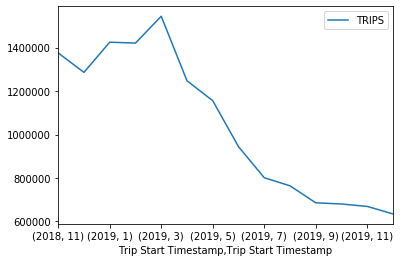

In [93]:
df_month.plot( y= 'TRIPS')

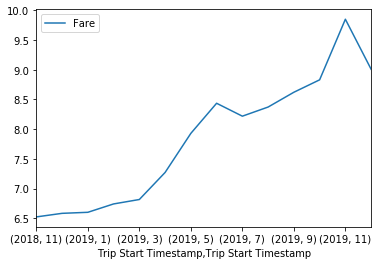

In [94]:
df_month.plot( y= 'Fare')

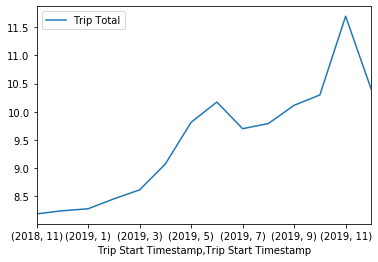

In [95]:
df_month.plot( y= 'Trip Total')

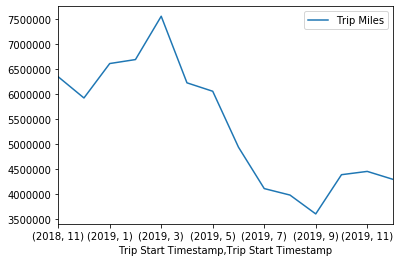

In [96]:
df_month.plot( y= 'Trip Miles')

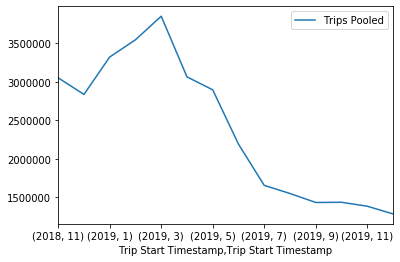

In [97]:
df_month.plot( y= 'Trips Pooled')

In [12]:
store.close()

# Iterate through the tod tables to create plots of trips

In [3]:
tods = [1,2,3,4,5,6,7,8]

In [4]:
agg = {'Fare':'mean','PRIVATE_FARE':'mean','SHARED_FARE':'mean','Trip Total':'mean','Trip Miles':'sum','Trips Pooled':'sum','PRIVATE_TRIPS':'sum','SHARED_TRIPS':'sum','TRIPS':'sum'}

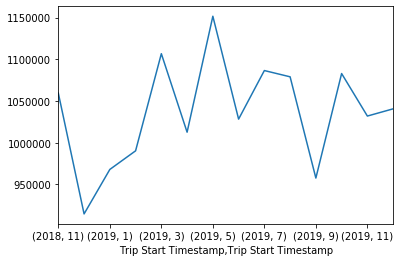

In [17]:
plot = df['TRIPS'].plot()

In [33]:
fig = plot.get_figure()

In [38]:
fig.clear()

In [40]:
for tod in tods:
    print("Working on tod " + str(tod))
    
    df = pd.read_hdf('C:/TNC Model/Input/Chicago_TNC_Trips.H5', key = 'Weekday_' + str(tod))
    
    df['TRIPS'] = 1
    df['SHARED_TRIPS'] = np.where(df['Shared Trip Authorized'] == True, 1, 0)
    df['PRIVATE_TRIPS'] = np.where(df['Shared Trip Authorized'] == False, 1, 0)
    df['SHARED_FARE'] = np.where(df['Shared Trip Authorized'] == True, df['Fare'], np.nan)
    df['PRIVATE_FARE'] = np.where(df['Shared Trip Authorized'] == False, df['Fare'], np.nan)
    
    df.index = df['Trip Start Timestamp']
    df = df.groupby(by = [df.index.year,df.index.month]).agg(agg)
    
    plot = df['TRIPS'].plot()
    fig = plot.get_figure()
    fig.savefig('Data Exploration/Trip Total Plots/TRIPS_' + str(tod) + '.pdf')
    fig.clear()
    
    plot = df['SHARED_TRIPS'].plot()
    fig = plot.get_figure()
    fig.savefig('Data Exploration/Trip Total Plots/SHARED_TRIPS_' + str(tod) + '.pdf')
    fig.clear()
    
    plot = df['PRIVATE_TRIPS'].plot()
    fig = plot.get_figure()
    fig.savefig('Data Exploration/Trip Total Plots/PRIVATE_TRIPS_' + str(tod) + '.pdf')
    fig.clear()
    
    plot = df['Fare'].plot()
    fig = plot.get_figure()
    fig.savefig('Data Exploration/Fare Plots/Fare_' + str(tod) + '.pdf')
    fig.clear()
    
    plot = df['SHARED_FARE'].plot()
    fig = plot.get_figure()
    fig.savefig('Data Exploration/Fare Plots/SHARED_FARE_' + str(tod) + '.pdf')
    fig.clear()
    
    plot = df['PRIVATE_FARE'].plot()
    fig = plot.get_figure()
    fig.savefig('Data Exploration/Fare Plots/PRIVATE_FARE_' + str(tod) + '.pdf')
    fig.clear()
    

Working on tod 1
Working on tod 2
Working on tod 3
Working on tod 4
Working on tod 5
Working on tod 6
Working on tod 7
Working on tod 8


<Figure size 432x288 with 0 Axes>

In [23]:
df_1['SHARED_TRIPS'] = np.where(df_1['Shared Trip Authorized'] == True, 1, 0)

In [24]:
df_1['PRIVATE_TRIPS'] = np.where(df_1['Shared Trip Authorized'] == False, 1, 0)

In [25]:
df_1.index = df_1['Trip Start Timestamp']

In [26]:
df_1.head()

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,YEAR,MONTH,DOW,HOUR,TRIPS,SHARED_TRIPS,PRIVATE_TRIPS
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,
2019-11-27 20:15:00,2019-11-27 20:15:00,2019-11-27 20:30:00,1333.0,17.534642,1.703198e+10,1.703184e+10,22.5,0.0,11.50,34.00,False,1.0,2019,11,2,20,1,0,1
2019-12-10 20:15:00,2019-12-10 20:15:00,2019-12-10 20:15:00,774.0,2.760000,1.703183e+10,1.703122e+10,7.5,0.0,2.55,10.05,False,1.0,2019,12,1,20,1,0,1
2019-11-26 20:45:00,2019-11-26 20:45:00,2019-11-26 21:00:00,489.0,2.240000,1.703107e+10,1.703106e+10,7.5,2.0,2.55,12.05,False,1.0,2019,11,1,20,1,0,1
2019-12-06 21:45:00,2019-12-06 21:45:00,2019-12-06 21:45:00,538.0,1.737452,1.703105e+10,1.703106e+10,5.0,0.0,2.55,7.55,True,5.0,2019,12,4,21,1,1,0
2019-10-18 23:15:00,2019-10-18 23:15:00,2019-10-18 23:15:00,298.0,1.156605,1.703104e+10,1.703103e+10,5.0,0.0,2.55,7.55,False,1.0,2019,10,4,23,1,0,1


In [79]:
df_1['MONTH_YEAR'] = df_1.apply(lambda row: str(row['Trip Start Timestamp'].year) + '_' + str(row['Trip Start Timestamp'].month),axis = 1)

In [ ]:
df_1

In [6]:
df_month_1['TRIPS'].plot()

NameError: name 'df_month_1' is not defined

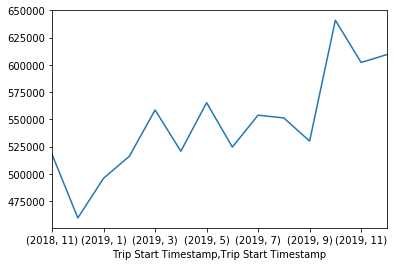

In [8]:
fig = df['PRIVATE_TRIPS'].plot()

In [72]:
df_month_1['DATES'] = plt.dates.date2num(df_month_1['Trip Start Timestamp'])

KeyError: 'Trip Start Timestamp'

In [74]:
df_month_1.head()

Fare  Trip Total    Trip Miles  \
Trip Start Timestamp Trip Start Timestamp                                       
2018                 11                    9.007105   12.171330  4.790020e+06   
                     12                    8.811540   11.928901  3.995638e+06   
2019                 1                     8.681615   11.830304  4.245528e+06   
                     2                     8.858943   12.010515  4.429812e+06   
                     3                     9.036601   12.233641  4.998819e+06   

                                           Trips Pooled  PRIVATE_TRIPS  \
Trip Start Timestamp Trip Start Timestamp                                
2018                 11                       1310522.0         836881   
                     12                       1125803.0         727608   
2019                 1                        1221484.0         759135   
                     2                        1284363.0         778229   
                     3                        1429316.0         878124   

                                           SHARED_TRIPS    TRIPS  
Trip Start Timestamp Trip Start Timestamp                         
2018                 11                          222529  1059410  
                     12                          186912   914520  
2019                 1                           208750   967885  
                     2                           211987   990216  
                     3                           228632  1106756

In [73]:
plt.pyplot.plot(df_month_1['Trip Start Timestamp'], df_month_1['SHARED_TRIPS'])

KeyError: 'Trip Start Timestamp'

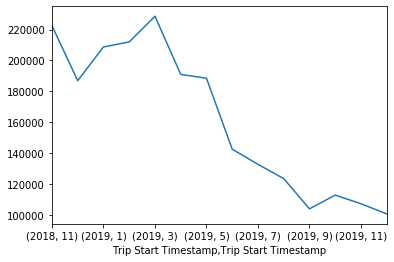

In [33]:
df_month_1['SHARED_TRIPS'].plot()

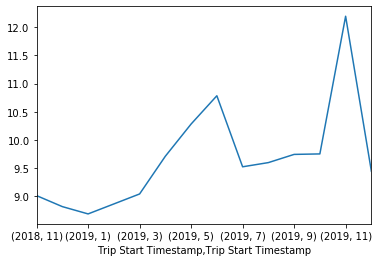

In [34]:
df_month_1['Fare'].plot()

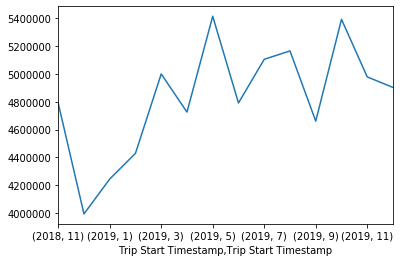

In [35]:
df_month_1['Trip Miles'].plot()